# CIFAR10 Train Model with CUDAGraph

## Setup

In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


loads images for training and validation and shows shape

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show 1 trainloader dimension
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([4, 3, 32, 32])
torch.Size([4])


shows images

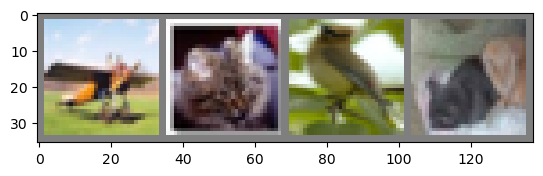

plane cat   bird  cat  


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Convolutional Neural Network (CNN)

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

static inputs and output for Cuda Graphs

In [5]:
# placeholder used for capture uses same transforms as training data
static_input = torch.randn(batch_size, 3, 32, 32, device=device).float()
static_labels =  torch.randint(0, 10, (batch_size,), device=device).long()
for i, data in enumerate(trainloader, 0):
    static_input.copy_(data[0])
    static_labels.copy_(data[1])
    break

## Training

In [6]:
start_time = time.perf_counter()
# warmup to allow for memory allocation
s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(5):
        optimizer.zero_grad()
        static_output = net(static_input)
        loss = criterion(static_output, static_labels)
        loss.backward()
        optimizer.step()
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture
g = torch.cuda.CUDAGraph()
optimizer.zero_grad(set_to_none=True)
with torch.cuda.graph(g):
    static_output = net(static_input)
    static_loss = criterion(static_output, static_labels)
    static_loss.backward()
    optimizer.step()
torch.cuda.synchronize()

# training
start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=2, active=5, repeat=1)
with torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/rtx3080/training_cudagraph_batch{batch_size}'),
    record_shapes=True,
) as prof:
    for epoch in range(2):  # loop over the dataset multiple times
        print(f'epoch {epoch + 1}')
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            static_input.copy_(data[0])
            static_labels.copy_(data[1])

            # replay
            g.replay()

            torch.cuda.synchronize()

            # print statistics
            running_loss += static_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

            prof.step()

end_time = time.perf_counter()
print('Finished Training')
print(f'Time taken: {end_time - start_time1:.2f}s')
print(f'Time taken with warmup and capture: {end_time - start_time:.2f}s')

epoch 1


STAGE:2024-03-13 11:25:09 6940:6940 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:25:09 6940:6940 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:25:09 6940:6940 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


[1,  2000] loss: 2.255
[1,  4000] loss: 1.858
[1,  6000] loss: 1.682
[1,  8000] loss: 1.596
[1, 10000] loss: 1.511
[1, 12000] loss: 1.475
epoch 2
[2,  2000] loss: 1.382
[2,  4000] loss: 1.378
[2,  6000] loss: 1.355
[2,  8000] loss: 1.299
[2, 10000] loss: 1.296
[2, 12000] loss: 1.278
Finished Training
Time taken: 20.42s
Time taken with warmup and capture: 20.82s


save model

In [7]:
PATH = f'./model/cifar_net_CUDAGraph{batch_size}.pth'
torch.save(net.state_dict(), PATH)

validation

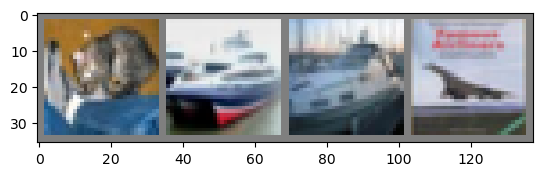

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

# print shape of output tensor
print(outputs.shape)

Predicted:  cat   ship  truck plane
torch.Size([4, 10])


performance for whole dataset

In [10]:
correct = 0
total = 0
static_input.copy_(images) # copy data for warmup into input

start_time = time.perf_counter()
# warmup
s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for _ in range(5):
        static_output = net(static_input)
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    static_output = net(static_input)
torch.cuda.synchronize()

start_time1 = time.perf_counter()
# since we're not training, we don't need to calculate the gradients for our outputs
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=2, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/rtx3080/validation_cudagraph_batch{batch_size}'),
    record_shapes=True,
) as prof:
    for data in testloader:

        # copy data
        static_input.copy_(data[0])
        static_labels.copy_(data[1])

        # replay graph
        g.replay()

        torch.cuda.synchronize()

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(static_output.data, 1)
        total += static_labels.size(0)
        correct += (predicted == static_labels).sum().item()
        prof.step()

end_time = time.perf_counter()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print(f'Time taken: {end_time - start_time1:.2f}s')
print(f'Time taken with warmup and capture: {end_time - start_time:.2f}s')

STAGE:2024-03-13 11:25:30 6940:6940 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:25:30 6940:6940 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:25:30 6940:6940 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Accuracy of the network on the 10000 test images: 53 %
Time taken: 1.98s
Time taken with warmup and capture: 2.06s
